# Imagenet Processing in parallel

In [137]:
%matplotlib inline
from bcolz_array_iterator import BcolzArrayIterator
from tqdm import tqdm
import gensim
import glob
import pickle
import numpy as np
from keras.utils.data_utils import get_file
import json
import keras.backend as K
import nltk
import os
import threading
import bcolz
from PIL import Image
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
import matplotlib.pyplot as plt

Set memory usage for TF (uses all by default)

In [2]:
K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

## Word Vectors

We'll try to do better than DeVISE and use Word2Vec trained og Google News.

In [5]:
path = '/home/mark/data/datasets/nlp/word2vec/'
w2v_path = '/home/mark/data/datasets/nlp/GoogleNews-vectors-negative300'
wn_path = '/home/mark/data/datasets/nlp/wordnet/'

In [6]:
model = gensim.models.KeyedVectors.load_word2vec_format(w2v_path+'.bin', binary=True)
model.save_word2vec_format(w2v_path+'.txt', binary=False)

Create .txt file for easier workflow

In [7]:
lines = open(w2v_path+'.txt').readlines(); len(lines)

3000001

In [8]:
def parse_w2v(line):
    i = line.index(' ')
    return line[:i], np.fromstring(line[i+1:-1], 'float32', sep=' ')

In [9]:
w2v_list = list(map(parse_w2v, lines[1:]))

Save processed file for quick access in the future.

In [10]:
pickle.dump(w2v_list, open(path+'/w2vl.pkl', 'wb'))

In [11]:
w2v_list = pickle.load(open(path+'/w2vl.pkl', 'rb'))

In [12]:
w2v_dict = dict(w2v_list)
words, vectors = zip(*w2v_list)

Test inputs

Should have positive correlation coeff.

In [13]:
np.corrcoef(w2v_dict['mark'], w2v_dict['Mark'])

array([[ 1.        ,  0.11157609],
       [ 0.11157609,  1.        ]])

Shouldn't have a positive correlation coeff.

In [14]:
np.corrcoef(w2v_dict['apple'], w2v_dict['Mark'])

array([[ 1.        , -0.00579598],
       [-0.00579598,  1.        ]])

We're only interested in lowercase part of word2vec

In [15]:
lowc_w2v = {w.lower(): w2v_dict[w] for w in reversed(words)}

We're going to map wordvectors for each of the 1000 categories in Imagenet to the 82,000 nouns in Wordnet.

#### 1000 Imagenet categories

In [16]:
fpath = get_file('imagenet_class_index.json',
                 'http://files.fast.ai/models/imagenet_class_index.json',
                 cache_subdir='models')

In [17]:
class_dict = json.load(open(fpath))
n_class = len(class_dict)

In [18]:
classids_1k = dict(class_dict.values())
len(classids_1k)

1000

#### ~82,000 nouns in Wordnet

In [19]:
wordnet = nltk.corpus.wordnet.all_synsets(pos='n');
wn_nouns = list(wordnet)

In [20]:
with open(os.path.join(wn_path, 'classids.txt'), 'w') as f:
    f.writelines(['n{:08d} {}\n'.format(n.offset(), n.name().split('.')[0]) for n in wn_nouns])

In [21]:
classid_lines = open(wn_path+'/classids.txt', 'r').readlines();
classids = dict(line.strip().split(' ') for line in classid_lines)
len(classids)

82115

#### Combined wordvectors

Synset matches

51,640 / 82,115 of categories in wordnet appears in word2vec

In [217]:
# create synset wordvector from wordnet categories
syn_wv = [(k, lowc_w2v[v.lower()]) for k, v in classids.items() if v.lower() in lowc_w2v]
len(syn_wv)

51640

774 / 1000 of categories in imagenet appear in word2vec

In [193]:
# create synset wordvector from imagenet categories
syn_wv_1k = [(k, lowc_w2v[v.lower()]) for k, v in classids_1k.items() if v.lower() in lowc_w2v]
len(syn_wv_1k)

774

In [101]:
syn2wv = dict(syn_wv); len(syn2wv)

51640

We'll remove the categories we can't find from the imagenet dataset

In [ ]:
# TODO

In [102]:
ndim = len(list(syn2wv.values())[0]); ndim

300

## Images

In [63]:
img_path = '/home/mark/data/imagenet/sample/'

Reading jpegs and resizing them can be slow, so we store the result.

In [64]:
fnames = list(glob.iglob(img_path+'train/*/*.JPEG'))
pickle.dump(fnames, open(img_path+'fnames.pkl', 'wb'))

In [65]:
len(fnames)

19439

Random shuffle

In [66]:
fnames = np.random.permutation(fnames)

In [67]:
pickle.dump(fnames, open(img_path+'fnames_r.pkl', 'wb'))

In [68]:
height, width = (224, 224)
n = len(fnames); n

19439

In [69]:
bc_path = f'{img_path}results/trn_resized{width}_r.bc'

In [80]:
def _resize(img):
    shortest = min(img.width, img.height)
    resized = np.round(np.multiply(height/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

In [71]:
def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: return
    return _resize(img)

In [72]:
def resize_img_bw(i):
    return _resize(Image.open(fnames[i]).convert('L'))

Pre-allocate memory in threadlocal storage

In [73]:
tl = threading.local()

In [74]:
tl.place = np.zeros((height, width, 3), 'uint8')

In [75]:
arr = bcolz.carray(np.empty((0, height, width, 3), 'float32'),
                   chunklen=16, mode='w', rootdir=bc_path)

#### Test performance

In [83]:
def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    # pre allocated array
    tl.place[:] = (np.array(r)[get_slice(r.size[1], height), get_slice(r.size[0], width)] if r else 0.)
    arr.append(tl.place)

Serial version

In [85]:
for i in tqdm(range(2000)): app_img(resize_img(i))
arr.flush()

100%|██████████| 2000/2000 [01:32<00:00, 21.52it/s]


Parallel version

In [94]:
step = 6400
for i in tqdm(range(0, n, step)):
    with ThreadPoolExecutor(max_workers=16) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res: app_img(r)
    arr.flush()


100%|██████████| 4/4 [03:29<00:00, 41.83s/it]


In [95]:
arr = bcolz.open(bc_path)

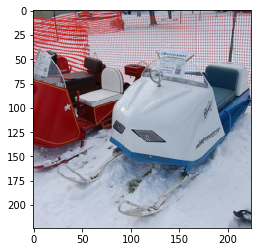

In [97]:
plt.imshow(arr[-2].astype('uint8'))

## Model

In [196]:
from keras.layers import Lambda, Input, AveragePooling2D, Flatten, Dense
from keras.applications.resnet50 import ResNet50, conv_block, identity_block
from keras.models import Sequential, Model
import keras.backend as K
from sklearn.neighbors import NearestNeighbors, LSHForest

In [100]:
fnames[0]

'/home/mark/data/imagenet/sample/train/n02120079/n02120079_12153.JPEG'

In [99]:
def get_synset(f): return f[f.rfind('/')+1:f.find('_')]

labels = list(map(get_synset, fnames))
labels[:5]

['n02120079', 'n02093647', 'n03930313', 'n02808440', 'n02422699']

In [103]:
vecs = np.stack([syn2wv[label] for label in labels]); vecs.shape

(19439, 300)

We'll be using Resnet50 as our pretrained model

In [141]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
inp = Input((224,224,3))
preprocess = Lambda(lambda x: (x - rn_mean)[:, :, :, ::-1])(inp)
model = ResNet50(include_top=False, input_tensor=preprocess)

In [142]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 224, 224, 3)   0           input_3[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        lambda_3[0][0]                   
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

#### Save intermediate activations

##### Last layer before the final convolutional bottleneck block(>< identity block)

In [170]:
mid_start = model.get_layer('res5b_branch2a')
mid_out = model.layers[model.layers.index(mid_start)-1]
shape = mid_out.output_shape; shape

(None, 7, 7, 2048)

Add AveragePooling layer to make it a more managable size and save it

In [171]:
rn_top = Model(model.input, mid_out.output)
rn_top_avg = Sequential([rn_top, AveragePooling2D((7, 7))])

In [172]:
shape = rn_top_avg.output_shape; shape

(None, 1, 1, 2048)

In [173]:
features_mid = bcolz.carray(np.empty((0,)+shape[1:]),
                            rootdir=img_path+'results/features_mid_1c_r.bc',
                            chunklen=16,
                            mode='w')

In [174]:
features_mid = bcolz.open(img_path+"results/features_mid_1c_r.bc"); features_mid.shape

(0, 1, 1, 2048)

To use memory more efficiently we'll split our data into batches and predict

In [175]:
def gen_features_mid(direction=1):
    gen = (arr[i:min(i+128, n)] for i in range(0, len(arr), 128))
    for i, batch in enumerate(gen):
        features_mid.append(rn_top_avg.predict_on_batch(batch[:,:,::-direction]))
        if (i%100==99):
            features_mid.flush()
            print(i)
    features_mid.flush()

In [176]:
gen_features_mid(1); features_mid.shape

99
199
299
399


(19439, 1, 1, 2048)

In [177]:
gen_features_mid(-1); features_mid.shape

99
199
299
399


(38878, 1, 1, 2048)

##### Our final layers will match the original Resnet

In [178]:
rn_bot_inp = Input(shape[1:])
x = rn_bot_inp
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
x = Flatten()(x)
rn_bot_model = Model(rn_bot_inp, x)

In [179]:
rn_bot_model.output_shape

(None, 2048)

Copy weights from ResNet50 model

In [180]:
for i in range(len(rn_bot_model.layers)-1):
    rn_bot_model.layers[-i-2].set_weights(model.layers[-i-2].get_weights())

Get predictions and save (here we don't have to predict on batches)

In [181]:
%time features_last = rn_bot_model.predict(features_mid, batch_size=128)

CPU times: user 2.49 s, sys: 308 ms, total: 2.8 s
Wall time: 2.56 s


In [182]:
features_last = bcolz.carray(features_last, rootdir=img_path+'results/features_last_r.bc',
                             chunklen=64, mode='w')

In [183]:
features_last = bcolz.open(img_path+'results/features_last_r.bc')[:]

#### Transfer predictions

Add a linear model on top to predict word vectors

In [184]:
linear_inp = Input(shape=(2048,))
linear_model = Model(linear_inp, Dense(ndim)(linear_inp))

#### Train

create cosine distance loss function (good choice for nearest neighbors)

In [185]:
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

In [186]:
linear_model.compile('adam', cos_distance)

In [187]:
v = np.concatenate([vecs, vecs])

In [188]:
linear_model.evaluate(features_last, v, verbose=0)

0.9985209631695412

In [189]:
linear_model.fit(features_last, v, verbose=2, epochs=4)

Epoch 1/4
2s - loss: 0.6553
Epoch 2/4
2s - loss: 0.6281
Epoch 3/4
2s - loss: 0.6143
Epoch 4/4
2s - loss: 0.6061


Save intermediate weights

In [191]:
linear_model.save_weights(img_path+'results/lm_cos.h5')

In [192]:
linear_model.load_weights(img_path+'results/lm_cos.h5')

#### Nearest Neighbors

We'll use nearest neighbors to look at the word vectors of the 1,000 imagenet categories

In [195]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

In [203]:
# nn = NearestNeighbors(3, metric='cosine', algorithm='brute').fit(wvs)
nn = LSHForest(20, n_neighbors=3).fit(wvs)

In [204]:
%time pred_wv = linear_model.predict(features_last[:10000])

CPU times: user 528 ms, sys: 68 ms, total: 596 ms
Wall time: 435 ms


In [205]:
%time dist, idxs = nn.kneighbors(pred_wv)

CPU times: user 2min 31s, sys: 1.9 s, total: 2min 33s
Wall time: 25.6 s


In [208]:
[[classids[syns[id]] for id in ids] for ids in idxs[180:200]]

[['border_terrier', 'miniature_poodle', 'irish_wolfhound'],
 ['wolf_spider', 'stinkhorn', 'arctic_fox'],
 ['irish_wolfhound', 'border_terrier', 'brittany_spaniel'],
 ['bluetick', 'silky_terrier', 'miniature_poodle'],
 ['hermit_crab', 'border_terrier', 'fiddler_crab'],
 ['tub', 'coffeepot', 'border_terrier'],
 ['wolf_spider', 'isopod', 'stinkhorn'],
 ['miniature_poodle', 'tibetan_terrier', 'border_terrier'],
 ['border_terrier', 'bluetick', 'tibetan_terrier'],
 ['isopod', 'garter_snake', 'stinkhorn'],
 ['border_terrier', 'irish_wolfhound', 'tibetan_terrier'],
 ['garter_snake', 'stinkhorn', 'isopod'],
 ['miniature_poodle', 'siamese_cat', 'garter_snake'],
 ['irish_wolfhound', 'tibetan_terrier', 'miniature_poodle'],
 ['proboscis_monkey', 'garter_snake', 'spoonbill'],
 ['tibetan_terrier', 'border_terrier', 'ibizan_hound'],
 ['stinkhorn', 'ringlet', 'ruddy_turnstone'],
 ['border_terrier', 'miniature_poodle', 'tibetan_terrier'],
 ['irish_wolfhound', 'border_terrier', 'brittany_spaniel'],
 ['mi

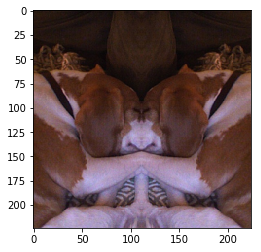

In [214]:
plt.imshow(arr[180].astype('uint8'))

Let's look up every wordnet synset id

In [220]:
all_syns, all_wvs = list(zip(*syn_wv))
all_wvs = np.array(all_wvs)

In [221]:
all_nn = LSHForest(20, n_neighbors=3).fit(all_wvs)

In [222]:
%time dist, idxs = all_nn.kneighbors(pred_wv[:200])

CPU times: user 18.7 s, sys: 212 ms, total: 18.9 s
Wall time: 3.15 s


In [223]:
[[classids[all_syns[id]] for id in ids] for ids in idxs[190:200]]

[['downy_woodpecker', 'staghorn_fern', 'epergne'],
 ['dishpan', 'horned_owl', 'hush_puppy'],
 ['dishpan', 'dishtowel', 'reindeer_moss'],
 ['fox_terrier', 'epergne', 'stonefish'],
 ['brown_creeper', 'belted_kingfisher', 'wolf_spider'],
 ['dishpan', 'scotch_egg', 'standard_poodle'],
 ['belted_kingfisher', 'insectivore', 'insectivore'],
 ['border_terrier', 'komondor', 'sego_lily'],
 ['scarlet_tanager', 'hoary_marmot', 'spring_peeper'],
 ['belted_kingfisher', 'corncrib', 'insectivore']]

#### Finetune

In [224]:
linear_inp2 = Input(shape=(2048,))
linear_model2 = Model(linear_inp2, Dense(ndim)(linear_inp2))

Transfer weights from earlier model

In [225]:
for l1, l2 in zip(linear_model.layers, linear_model2.layers):
    l2.set_weights(l1.get_weights())

In [230]:
rn_bot_seq = Sequential([rn_bot_model, linear_model2])
rn_bot_seq.compile('adam', 'cosine_proximity')
rn_bot_seq.output_shape

(None, 300)

In [242]:
bc_it = BcolzArrayIterator(features_mid, v, shuffle=True, batch_size=1024)

In [243]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-3)

In [244]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, epochs=4)

Epoch 1/4
38878/38878 [==============================] - 1084s - loss: -0.0020  
Epoch 2/4
38878/38878 [==============================] - 1083s - loss: -0.0021  
Epoch 3/4
38878/38878 [==============================] - 1084s - loss: -0.0021  
Epoch 4/4
38878/38878 [==============================] - 1083s - loss: -0.0021  


In [245]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-4)

In [246]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, epochs=8)

Epoch 1/8
38878/38878 [==============================] - 1084s - loss: -0.0021  
Epoch 2/8
38878/38878 [==============================] - 1083s - loss: -0.0021  
Epoch 3/8
38878/38878 [==============================] - 1083s - loss: -0.0021  
Epoch 4/8
38878/38878 [==============================] - 1083s - loss: -0.0021  
Epoch 5/8
38878/38878 [==============================] - 1083s - loss: -0.0021  
Epoch 6/8
38878/38878 [==============================] - 1083s - loss: -0.0021  
Epoch 7/8
38878/38878 [==============================] - 1083s - loss: -0.0021  
Epoch 8/8
38878/38878 [==============================] - 1083s - loss: -0.0021  


In [247]:
rn_bot_seq.save_weights(img_path+'results/rn_bot_seq_cos.h5')

In [248]:
rn_bot_seq.load_weights(img_path+'results/rn_bot_seq_cos.h5')

#### Nearest Neighbors (again)

In [249]:
%time pred_wv = rn_bot_seq.predict(features_mid)

CPU times: user 9.02 s, sys: 1.38 s, total: 10.4 s
Wall time: 19.5 s


In [250]:
rng = slice(190, 200)

In [251]:
dist, idxs = nn.kneighbors(pred_vw[rng])

In [252]:
[[classids[syns[id]] for id in ids] for ids in idxs]

[['border_terrier', 'irish_wolfhound', 'tibetan_terrier'],
 ['garter_snake', 'stinkhorn', 'isopod'],
 ['miniature_poodle', 'siamese_cat', 'garter_snake'],
 ['irish_wolfhound', 'tibetan_terrier', 'miniature_poodle'],
 ['proboscis_monkey', 'garter_snake', 'spoonbill'],
 ['tibetan_terrier', 'border_terrier', 'ibizan_hound'],
 ['stinkhorn', 'ringlet', 'ruddy_turnstone'],
 ['border_terrier', 'miniature_poodle', 'tibetan_terrier'],
 ['irish_wolfhound', 'border_terrier', 'brittany_spaniel'],
 ['miniature_poodle', 'irish_wolfhound', 'brittany_spaniel']]

In [255]:
dist, idxs = all_nn.kneighbors(pred_wv[rng])

In [256]:
[[classids[all_syns[id]] for id in ids] for ids in idxs]

[['wing', 'wing', 'wing'],
 ['teapot', 'norfolk_terrier', 'armlet'],
 ['cicada', 'wolf_spider', 'critter'],
 ['german_shepherd', 'cocker_spaniel', 'golden_retriever'],
 ['purple_gallinule', 'cattle_egret', 'binturong'],
 ['dishtowel', 'washtub', 'dishrag'],
 ['dung_beetle', 'critter', 'indigo_snake'],
 ['black_swan', 'bikini', 'bikini'],
 ['scarlet_tanager', 'frog', 'frog'],
 ['tommy_gun', 'bowie_knife', 'hatpin']]

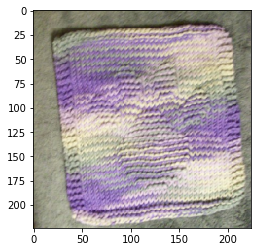

In [261]:
plt.imshow(arr[rng][5].astype('uint8'))